# Imports/functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from matplotlib.gridspec import GridSpec
import glob
fs_axislabel = 10
fs_figsubpanel = 14
fs_legend = 8

In [2]:
import itertools
def plot(toplot, options, axs, names=None, colors=None, make=['power','fdr','accuracy'], ylabel=False, xlabel=False,
         xticks=True, legend='', fontsize=12):
    for o, t in enumerate(make):
        if t == 'power':
            for i, repname in enumerate(itertools.product(*options)):
                repname = ''.join(repname)
                name = repname if names is None else names[i]
                color = None if colors is None else colors[i]
                mytoplot = toplot[toplot.repname == repname]
                if len(mytoplot) > 0:
                    axs[o].errorbar(mytoplot.noise + i/200, mytoplot.power,
                                 marker='.',
                                 yerr=mytoplot.power_stderr,
                                 label=name,
                                 color=color)
            if ylabel:
                axs[o].set_ylabel('Power', fontsize=fontsize)
            axs[o].set_ylim(-0.05,1.05)
            axs[o].set_yticks([0,1], ['0.0','1.0'])
    
        if t == 'fdr':
            for i, repname in enumerate(itertools.product(*options)):
                repname = ''.join(repname)
                name = repname if names is None else names[i]
                color = None if colors is None else colors[i]
                mytoplot = toplot[toplot.repname == repname]
                if len(mytoplot) > 0:
                    axs[o].errorbar(mytoplot.noise + i/200, mytoplot.nfdr10,
                                 yerr=mytoplot.nfdr10_stderr,
                                 marker='.',
                                 label=name,
                                 color=color)
            if ylabel:
                axs[o].set_ylabel('#Microniches at FDR 10%', fontsize=fontsize)
    
        if t == 'accuracy':
            for i, repname in enumerate(itertools.product(*options)):
                repname = ''.join(repname)
                name = repname if names is None else names[i]
                color = None if colors is None else colors[i]
                mytoplot = toplot[toplot.repname == repname]
                if len(mytoplot) > 0:
                    axs[o].errorbar(mytoplot.noise + i/200, mytoplot.accuracy,
                                 yerr=mytoplot.accuracy_stderr,
                                 marker='.',
                                 label=name,
                                 color=color)
            if ylabel:
                axs[o].set_ylabel('Spatial accuracy', fontsize=fontsize)
            axs[o].set_ylim(0.45, 1.05)
            axs[o].set_yticks([0.5,1])
            
    if legend in make:
        axs[make.index(legend)].legend(fontsize=fs_legend)
    if xlabel:
        axs[-1].set_xlabel('Noise', fontsize=fontsize)
    for ax in axs:
        if xticks:
            ax.set_xticks(info.noise.unique())
        else:
            ax.set_xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Load data

In [3]:
# read files
results = pd.concat([
    pd.read_csv(f, sep='\t', keep_default_na=False)
    for f in glob.glob(f'../../ALZ/alz-sim/out/*/*.*.tsv')])
results.repname.value_counts()

repname
resnetadvancedkl5-raw      3000
simplecnnkl5-latent-raw     900
allpixels-20pcs             900
resnetsimplekl5-raw         900
avg-raw                     900
resnetadvancedkl4-raw       600
resnetadvancedkl3-raw       600
resnetadvancedkl1-raw       600
resnetadvancedkl7-raw       600
resnetadvancedkl9-raw       600
resnetadvancedkl2-raw       600
resnetadvancedkl10-raw      600
resnetadvancedkl8-raw       600
resnetadvancedkl6-raw       600
resnetadvancedkl0-raw       156
Name: count, dtype: int64

In [4]:
# process results
accuracies = []
for signal in results.signal.unique():
    for style in results['style'].unique():
        for repname in results.repname.unique():
            mask = (results.repname==repname) & (results['style']==style) & (results.signal == signal)
            accuracy = results[mask].groupby(by='noise').auroc.aggregate(by="mean").by
            accuracy_std = results[mask].groupby(by='noise').auroc.aggregate(by="std").by
            n = results[mask].noise.value_counts()
            stderr = 2*accuracy_std / np.sqrt(n)
            df = pd.DataFrame({
                'accuracy':accuracy,
                'n':n,
                'accuracy_stderr':stderr})
            df['repname'] = repname
            df['style'] = style
            df['signal'] = signal
            accuracies.append(df)
accuracies = pd.concat(accuracies).reset_index()

powers = []
for signal in results.signal.unique():
    for style in results['style'].unique():
        for repname in results.repname.unique():
            mask = (results.repname==repname) & (results['style']==style) & (results.signal == signal)
            power = results[mask].groupby(by='noise').P.aggregate(by=lambda x:(x<=0.05).mean()).by
            strongpower = results[mask].groupby(by='noise').P.aggregate(by=lambda x:(x<=0.005).mean()).by
            n = results[mask].noise.value_counts()
            stderr = 2*np.sqrt(power*(1-power)/n)
            strongstderr = 2*np.sqrt(strongpower*(1-strongpower)/n)
            df = pd.DataFrame({
                'power':power,
                'power_stderr':stderr,
                'strongpower':strongpower,
                'strongpower_stderr':strongstderr})
            df['repname'] = repname
            df['style'] = style
            df['signal'] = signal
            powers.append(df)
powers = pd.concat(powers).reset_index()

nfdr10s = []
for signal in results.signal.unique():
    for style in results['style'].unique():
        for repname in results.repname.unique():
            mask = (results.repname==repname) & (results['style']==style) & (results.signal == signal)
            nfdr10 = results[mask].groupby(by='noise').nfdr10.aggregate(by="mean").by
            nfdr10_std = results[mask].groupby(by='noise').nfdr10.aggregate(by="std").by
            n = results[mask].noise.value_counts()
            stderr = 2*nfdr10_std / np.sqrt(n)
            df = pd.DataFrame({
                'nfdr10':nfdr10,
                'nfdr10_stderr':stderr})
            df['repname'] = repname
            df['style'] = style
            df['signal'] = signal
            nfdr10s.append(df)
nfdr10s = pd.concat(nfdr10s).reset_index()

info = pd.merge(accuracies, powers, on=['repname','style','signal','noise'])
info = pd.merge(info, nfdr10s, on=['repname','style','signal','noise'])

# Figures

## Main text figure

In [106]:
# generate patch examples for each signal type
import vima.data.samples as vds
import vimasim.synthesize as synthesize
synthesize.init(cellspath='../../ALZ/alz-data/SEAAD_MTG_MERFISH_metadata.2024-05-03.noblanks.harmonized.txt')

repname = 'pca_k=10_harmony'
samples = vds.read_samples(f'../../ALZ/alz-data/10u/{repname}/*.nc', vds.default_parser)
sid = list(samples.keys())[0]

modified_samples = []
for signal, caseval, ctrlval in [(synthesize.add_aggregates_v_nothing, 1, 0),
               (synthesize.add_aggregates_v_diffuse, 1, 0),
               (synthesize.add_linear_v_circular, 0, 1)]:
    ctrl = {sid:samples[sid].copy()}
    case = {sid:samples[sid].copy()}
    ctrl, sm0, _ = signal(ctrl, plot=False, forcecase=caseval)
    case, sm1, _ = signal(case, plot=False, forcecase=ctrlval)
    s0 = ctrl[sid]
    s1 = case[sid]
    modified_samples.append([s0, s1])

x1, x2 = 5200, 5600
y1, y2 = 5800, 6200
patches = []
for s0, s1 in modified_samples:
    p0 = s0.where((s0.x >= x1) & (s0.x <= x2) & (s0.y >= y1) & (s0.y <= y2), drop=True)
    p1 = s1.where((s1.x >= x1) & (s1.x <= x2) & (s1.y >= y1) & (s1.y <= y2), drop=True)
    patches.append([p0, p1])

100%|███████████████████████████████████████████████████████████████| 75/75 [00:09<00:00,  7.78it/s]


1217500814 1|1217500814 0|1217500814 1|1217500814 0|1217500814 0|noise 0.5 : 1.0 0.0
1217500814 1|noise 0.5 : 1.0 0.0


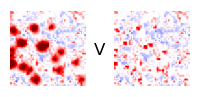

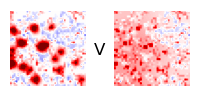

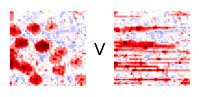

In [130]:
for name, patchpair in zip(['agg_v_nothing', 'agg_v_diffuse', 'agg_v_linear'], patches):
    fig = plt.figure(figsize=(2.32, 1))
    gs = GridSpec(1, 3, width_ratios=[1, 0.1, 1])

    for ax, p in zip([fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,2])], patchpair):
        ax.imshow(p.sel(marker='hPC2').data, vmin=-10, vmax=10, cmap='seismic')
        ax.axis('off')
    ax = fig.add_subplot(gs[0,1])
    ax.text(0.5, 0.47, 'V', ha='center', va='center', fontsize=12 ); ax.axis('off')
    plt.savefig(f'_media/{name}.png', dpi=500, bbox_inches='tight', pad_inches=0)
    plt.show()

In [131]:
mainreps = np.array([
    'resnetadvancedkl5-raw',
    'simplecnnkl5-latent-raw',
    'allpixels-20pcs',
    'avg-raw',
    ])
mainrep_names = ['VIMA',
                 '2-layer CNN',
                 'PCA of raw pixels (20)',
                 'Patch avg.']

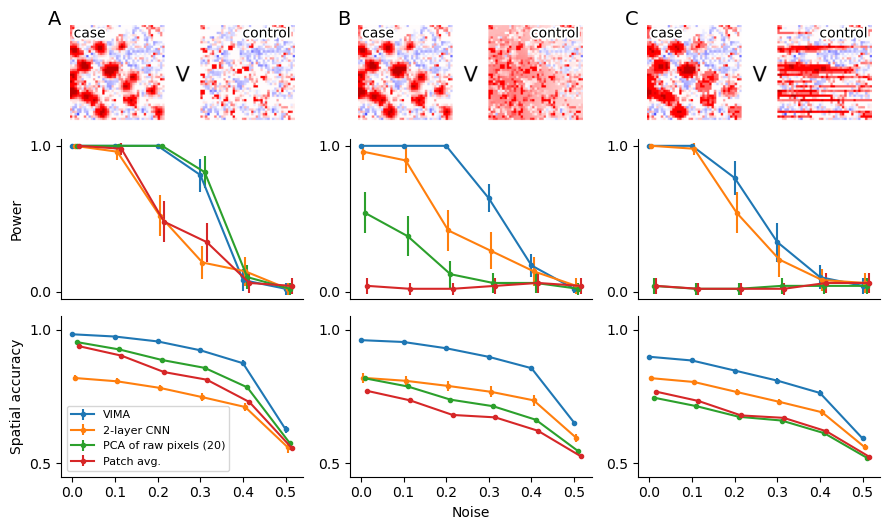

In [134]:
from matplotlib.patheffects import withStroke

fig = plt.figure(figsize=(9, 7/12*9))
gs = GridSpec(3, 3, height_ratios=[0.6, 1, 1])

# add pics of sim types
for i, pic in enumerate(['_media/agg_v_nothing.png', '_media/agg_v_diffuse.png', '_media/agg_v_linear.png']):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(ImageEnhance.Color(Image.open(pic)).enhance(1.7))
    text1 = ax.text(15, 5, 'case', va='top', ha='left', color='k', fontsize=10)
    text2 = ax.text(690, 5, 'control', va='top', ha='left', color='k', fontsize=10)
    for text in [text1, text2]:
        text.set_path_effects([withStroke(linewidth=3, foreground='white')])
    ax.axis('off')

# plot results
ax_power = [fig.add_subplot(gs[1,i]) for i in range(3)]
ax_acc = [fig.add_subplot(gs[2,i]) for i in range(3)]
options = (mainreps,)
for i, signal in enumerate(['agg_v_nothing','agg_v_diffuse','linear_v_circular']):
    toplot = info[(info['style'] == 'cna')&(info.signal == signal)]
    plot(toplot, options,
         ax_power[i:i+1],
         make=['power'], ylabel=i==0, legend='',
         fontsize=fs_axislabel, xticks=False,
         names=mainrep_names)
    plot(toplot, options,
         ax_acc[i:i+1],
         make=['accuracy'], ylabel=i==0, xlabel=i==1, legend='accuracy' if i==0 else '',
         fontsize=fs_axislabel,
         names=mainrep_names)
        
# add subpart labels
fig.tight_layout()
for i in range(3):
    fig.text(ax_power[i].get_position().x0, 1, ['A','B','C'][i], fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.savefig('../_main/fig.power_accuracy.pdf', dpi=800)
fig.savefig('../_main/fig.power_accuracy.png', dpi=500)
plt.show()

## Supp figures

### null simulation

In [7]:
toplot = results[(results.repname == 'resnetadvancedkl5-raw')&(results.signal=='null')&(results['style']=='cna')]
type1err = (toplot.P <= 0.05).sum() / len(toplot)
stderr = type1err * (1-type1err) / np.sqrt(len(toplot)) * 2
print(type1err, stderr)

0.03 0.003360178566683621


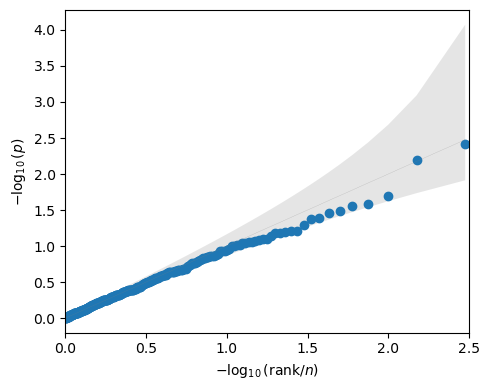

In [8]:
from statutils.vis import qqplot
plt.figure(figsize=(5,4))
qqplot(toplot.P)
plt.savefig('../_supp/fig.sim.nullcalib.png', dpi=500)
plt.show()

### VIMA but with clustering

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_40737/608065877.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


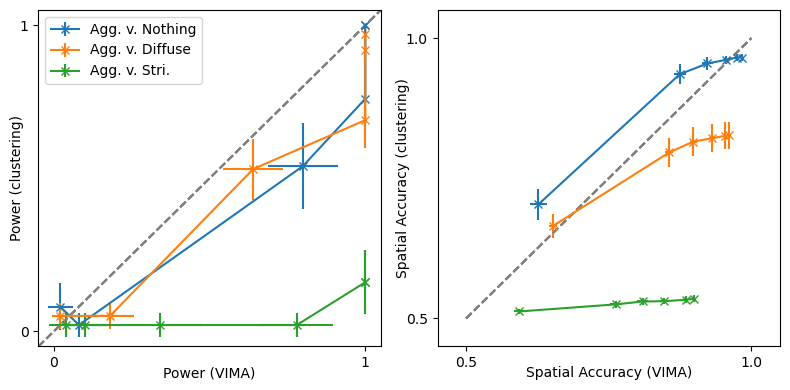

In [9]:
subset = info[(info.repname == 'resnetadvancedkl5-raw')&(info.signal!='null')]
vima = subset[subset['style'] == 'cna']
clust = subset[subset['style'] == 'clust']
# pd.merge(vima, clust, left_on=['signal','noise'
toplot = pd.merge(vima, clust, left_on=['noise','signal'], right_on=['noise','signal'])

f, axs = plt.subplots(1,2, figsize=(8,4))
for signal, label in [('agg_v_nothing', 'Agg. v. Nothing'), ('agg_v_diffuse', 'Agg. v. Diffuse'), ('linear_v_circular', 'Agg. v. Stri.')]:
    df = toplot[toplot.signal==signal]
    axs[0].errorbar(df.power_x, df.power_y, xerr=df.power_stderr_x, yerr=df.power_stderr_y, marker='x', label=label)
    axs[1].errorbar(df.accuracy_x, df.accuracy_y, xerr=df.accuracy_stderr_x, yerr=df.accuracy_stderr_y, marker='x', label=label)
    axs[0].plot([-0.05, 1.05],[-0.05,1.05], ls='--', color='grey')
    axs[1].plot([0.5,1],[0.5,1], ls='--', color='grey')
    axs[0].legend()
for ax, name, min, max in zip(axs, ['Power','Spatial Accuracy'], [0, 0.5], [1, 1]):
    ax.set_xlim(min-0.05, max+0.05); ax.set_ylim(min-0.05, max+0.05)
    ax.set_xticks([min,max]); ax.set_yticks([min,max])
    ax.set_xlabel(f'{name} (VIMA)', labelpad=-3); ax.set_ylabel(f'{name} (clustering)', labelpad=-3)
f.tight_layout()
f.savefig('../_supp/fig.sim.microniche_vs_clust.png', dpi=500)
f.show()

### VIMA vs comparators with FDR metric

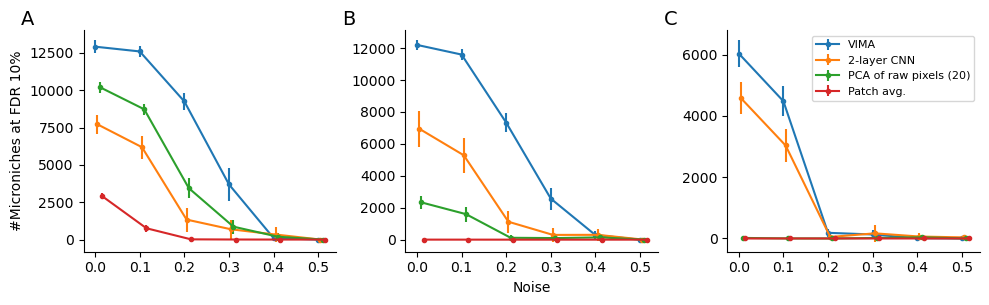

In [10]:
fig, axs = plt.subplots(1,3, figsize=(10, 3))

# plot results
options = (mainreps,)
for i, signal in enumerate(['agg_v_nothing','agg_v_diffuse','linear_v_circular']):
    toplot = info[(info['style'] == 'cna')&(info.signal == signal)]
    plot(toplot, options,
         axs[i:i+1],
         make=['fdr'], ylabel=i==0, xlabel=i==1, legend='fdr' if i == 2 else False,
         fontsize=fs_axislabel, xticks=True,
         names=mainrep_names)
        
# add subpart labels
fig.tight_layout()
for i in range(3):
    fig.text(axs[i].get_position().x0 - 0.05, 1, ['A','B','C'][i], fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.savefig('../_supp/fig.sim.sig_microniches.png', dpi=800)
plt.show()

### change variational penalty

In [11]:
mainreps = np.array([
    'resnetadvancedkl0-raw',
    'resnetadvancedkl1-raw',
    'resnetadvancedkl2-raw',
    'resnetadvancedkl3-raw',
    'resnetadvancedkl4-raw',
    'resnetadvancedkl5-raw',
    'resnetadvancedkl6-raw',
    'resnetadvancedkl7-raw',
    'resnetadvancedkl8-raw',
    # 'resnetadvancedkl9-raw',
    # 'resnetadvancedkl10-raw',
    ])
kls = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
klnames = ['0'] + [f'10^{{{int(np.log10(kl))}}}' for kl in kls[1:]]
mainrep_names = [f'VIMA ($\\beta={name}$)' for name in klnames]
mainrep_names

['VIMA ($\\beta=0$)',
 'VIMA ($\\beta=10^{-8}$)',
 'VIMA ($\\beta=10^{-7}$)',
 'VIMA ($\\beta=10^{-6}$)',
 'VIMA ($\\beta=10^{-5}$)',
 'VIMA ($\\beta=10^{-4}$)',
 'VIMA ($\\beta=10^{-3}$)',
 'VIMA ($\\beta=10^{-2}$)',
 'VIMA ($\\beta=10^{-1}$)',
 'VIMA ($\\beta=10^{0}$)',
 'VIMA ($\\beta=10^{1}$)']

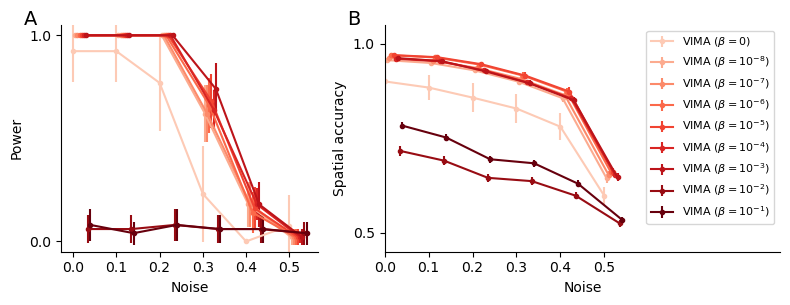

In [12]:
from matplotlib.patheffects import withStroke

fig = plt.figure(figsize=(8, 3))
gs = GridSpec(1, 2, width_ratios=[1.3,2])

# plot results
ax_power = fig.add_subplot(gs[0,0])
ax_acc = fig.add_subplot(gs[0,1])
options = (mainreps,)
signal = 'agg_v_diffuse'
toplot = info[(info['style'] == 'cna')&(info.signal == signal)]
plot(toplot, options,
     [ax_power],
     make=['power'], ylabel=True, xlabel=True, legend='',
     fontsize=fs_axislabel, xticks=True,
     names=mainrep_names,
     colors=plt.cm.Reds(np.linspace(0.2, 1, len(mainreps))))
plot(toplot, options,
     [ax_acc],
     make=['accuracy'], ylabel=True, xlabel=True, legend='accuracy',
     fontsize=fs_axislabel,
     names=mainrep_names,
     colors=plt.cm.Reds(np.linspace(0.2, 1, len(mainreps))))
ax_acc.set_xlim(0,0.9)
        
# add subpart labels
fig.tight_layout()
for label, ax in zip(['A','B'], [ax_power, ax_acc]):
    fig.text(ax.get_position().x0-0.03, 1, label, fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.savefig('../_supp/fig.sim.varykl.png', dpi=800)
plt.show()